In [155]:
%matplotlib inline

This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is an GRU.

# todos:
* regularization
* save/load model
* load pre-trained embedding
* mini-batching
* make sure it runs on GPU

In [20]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [21]:
use_cuda

False

In [22]:
# prepare data: load the input file containing list of list of list, and corresponding label file
# and output the merged list of pairs
import sys, random
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

# set random seed
random.seed( 3 )

seqFile = 'data/cerner/hospital_data/h143.visits'
labelFile = 'data/cerner/hospital_data/h143.labels'
set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')

labeled_ehr_seq_list = [(set_y[i],set_x[i]) for i in range(len(set_x))] # merge the two lists

In [151]:
class CNN_EHR(nn.Module):
    
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes, dropout):
        super(CNN_EHR, self).__init__()
        
        V = embed_num
        D = embed_dim
        self.D = D
        C = 1
        Ci = 1
        Co = kernel_num
        Ks = kernel_sizes

        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv1d(D, Co, K, padding=2) for K in Ks])
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks)*Co, C)
        self.sigmoid = nn.Sigmoid()

    def EmbedPatient(self, x): # x is a ehr_seq_tensor
        for i in range(len(x)):
            emb = self.embed(x[i]).view(-1, 1, self.D)
            emb = torch.sum(emb, dim=0).view(1,1,-1)
            if i==0:
                y = emb
            else:
                y = torch.cat((y, emb), 0)
                
        return y

    def forward(self, input):
        x = self.EmbedPatient(input) # []
        x = x.permute(1,2,0) # [N, Co, W]
        
        x = [F.relu(conv(x)) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        y = self.sigmoid(logit)
        return y

In [152]:
''' # for debugging
model = CNN_EHR(embed_num=20000, embed_dim=128, kernel_num=64, kernel_sizes=[2,3,4], dropout=0.5)
output, loss = train(label_tensor, ehr_seq_tensor, criterion = nn.BCELoss(), optimizer = optimizer)
'''

In [147]:
# training one sample, model is a global variable
def train(label_tensor, ehr_seq_tensor, criterion, optimizer):
    # hidden = model.initHidden()

    model.zero_grad()

    # for i in range(len(ehr_seq_tensor)):
    output = model(ehr_seq_tensor)

    loss = criterion(output, label_tensor)
    loss.backward()

    optimizer.step()
   
    return output, loss.data[0]


In [148]:
criterion = nn.BCELoss()
optimizer = optimizer
print(label_tensor)
loss = criterion(output, label_tensor)

output

Variable containing:
 0
[torch.FloatTensor of size 1x1]



Variable containing:
 0.9823
[torch.FloatTensor of size 1x1]

In [26]:
def variableFromEHRSeq(ehr_seq):
    # ehr_seq is a list of list
    result = []
    if use_cuda:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])).cuda() )
    # if use_cuda:
    #     return result.cuda()
    else:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])) )

    return result

In [157]:
# training all samples in random order
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

input_size = 20000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [158]:


start = time.time()

learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for iter in range(1, n_iters + 1):
    label, ehr_seq = random.choice(labeled_ehr_seq_list)
    label_tensor = Variable(torch.FloatTensor([[float(label)]]))
    if use_cuda:
        label_tensor = label_tensor.cuda() 
    ehr_seq_tensor = variableFromEHRSeq(ehr_seq)
    
    output, loss = train(label_tensor, ehr_seq_tensor, criterion = nn.BCELoss(), optimizer = optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (4m 35s) 0.4147 
10000 10% (8m 55s) 0.1041 
15000 15% (13m 14s) 0.3307 
20000 20% (17m 39s) 0.1934 
25000 25% (22m 6s) 0.2121 
30000 30% (27m 25s) 0.0361 
35000 35% (32m 58s) 0.0559 
40000 40% (38m 32s) 0.1654 
45000 45% (44m 14s) 0.0474 
50000 50% (49m 49s) 0.2272 
55000 55% (55m 35s) 0.0567 
60000 60% (61m 12s) 0.0108 
65000 65% (66m 51s) 0.1522 
70000 70% (72m 26s) 0.0928 
75000 75% (77m 52s) 3.5484 
80000 80% (83m 29s) 0.0208 
85000 85% (89m 11s) 0.0200 
90000 90% (94m 55s) 0.0026 
95000 95% (100m 38s) 0.0546 
100000 100% (106m 19s) 0.0886 


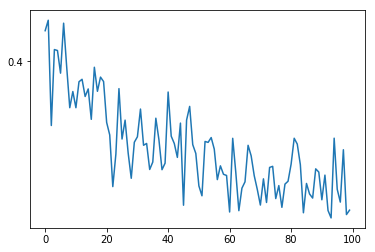

In [159]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
showPlot(all_losses)

In [ ]:
# validation/test


In [160]:
all_losses

[0.42467715333494155,
 0.4331282414672987,
 0.3480777683137659,
 0.4094431213326579,
 0.40866638012608747,
 0.39037155057553174,
 0.43074973427887014,
 0.39540955548109924,
 0.362456188692021,
 0.37552175030121,
 0.3624393360157119,
 0.38341074868936265,
 0.38542393971676936,
 0.3715183327484265,
 0.3776131121909639,
 0.35305821991816627,
 0.3951356631015369,
 0.37570321529940703,
 0.3871815439494967,
 0.3835825099856993,
 0.3505413877237406,
 0.34041913974512134,
 0.29869047477151617,
 0.32500012949385565,
 0.37786373562552034,
 0.3371350336668547,
 0.3524043724120565,
 0.32571933235921824,
 0.30542004233734044,
 0.3345363520222163,
 0.33892972466952054,
 0.3613526300988742,
 0.3320993872998515,
 0.33354662398179064,
 0.3125334645794646,
 0.31851766412433064,
 0.3539627218013811,
 0.33661845682177227,
 0.3123603217380296,
 0.317602928321925,
 0.37512760172132403,
 0.33944016516886766,
 0.3335221822898602,
 0.32230346942541654,
 0.3500138236489147,
 0.2836479840762331,
 0.3524733383758